In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow_datasets as tfds

tfkl = tfk.layers

1.

In [2]:
data, info = tfds.load('cifar10', with_info=True)
print(info)

Shuffling and writing examples to /Users/xiyuchen/tensorflow_datasets/cifar10/3.0.2.incomplete9U77MC/cifar10-train.tfrecord


Shuffling and writing examples to /Users/xiyuchen/tensorflow_datasets/cifar10/3.0.2.incomplete9U77MC/cifar10-test.tfrecord


Dataset cifar10 downloaded and prepared to /Users/xiyuchen/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='cifar10',
    version=3.0.2,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features from tiny images},
        institution = {},
        year = {2009}
    

In [3]:
train = data['train']
test = data['test']

In [4]:
len(train)

50000

In [5]:
img_shape = info.features['image'].shape
print(img_shape)
print(np.prod(img_shape))

(32, 32, 3)
3072


In [6]:
encoder = tfk.Sequential([
  tfkl.InputLayer(img_shape),
  tfkl.Conv2D(32,(4,4), activation=tf.nn.relu,padding="same"),
  tfkl.MaxPooling2D((2,2),padding="same"),
  tfkl.Conv2D(16,(3,3), activation=tf.nn.relu,padding="same"),
  tfkl.MaxPooling2D((2,2),padding="same")
])
encoder.summary()

decoder = tfk.Sequential([
  tfkl.InputLayer((8,8,16)),

  tfkl.Conv2D(16,(3,3), activation=tf.nn.relu,padding="same"),
  tfkl.UpSampling2D((2,2)),
  tfkl.Conv2D(32,(4,4), activation=tf.nn.relu,padding="same"),
  tfkl.UpSampling2D((2,2)),
  tfkl.Conv2D(3,(3,3), activation=tf.nn.relu,padding="same"),
])
decoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        1568      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 16)          0         
Total params: 6,192
Trainable params: 6,192
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 8, 8, 16)          2320      
________________________________

In [7]:
preprocess = lambda d: (tf.cast(d['image'], tf.float32)/255., d['label'])

ds_train = data['train'].map(preprocess).map(lambda x, y: (x, x)).cache().batch(32).repeat().prefetch(5)
ds_test = data["test"].map(preprocess)

ds_train

<PrefetchDataset shapes: ((None, 32, 32, 3), (None, 32, 32, 3)), types: (tf.float32, tf.float32)>

In [8]:

x = tfkl.Input(img_shape)

# we can then pass this placeholder through our models to specify the computation to get a prediction
h = encoder(x)
xhat = decoder(h)

# finally we use the tfk.Model class instantiate the model by specifying the inputs and outputs
# (note: this can also be lists, which is how you make more complex models with multiple inputs and/or outputs)
autoencoder = tfk.Model(inputs=x, outputs=xhat)
autoencoder.summary()

# training happens as usual
autoencoder.compile(
    optimizer=tfk.optimizers.Adam(),
    loss=tfk.losses.BinaryCrossentropy(),
)

results = autoencoder.fit(ds_train, steps_per_epoch=100, epochs=20)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 8, 8, 16)          6192      
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 32, 3)         11411     
Total params: 17,603
Trainable params: 17,603
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
100/100 [==============================] - 5s 47ms/step - loss: 0.6922
Epoch 2/20
100/100 [==============================] - 4s 45ms/step - loss: 0.6050
Epoch 3/20
100/100 [==============================] - 4s 44ms/step - loss: 0.5925
Epoch 4/20
100/100 [==============================] - 4s 43ms/step - loss: 0.5801
Epoch 5/20
100/100 [==============================] 

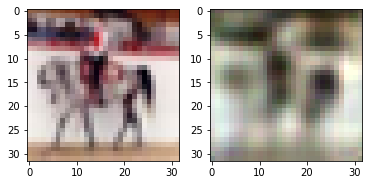

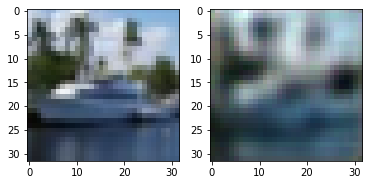

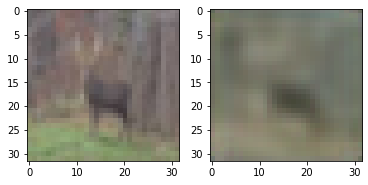

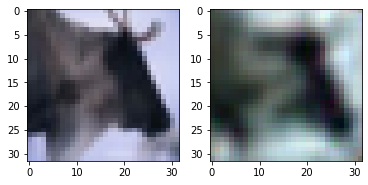

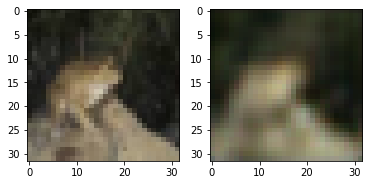

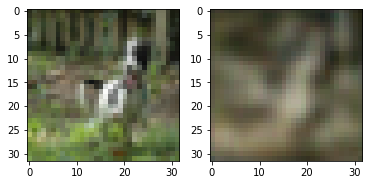

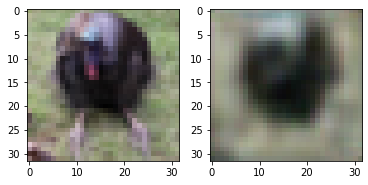

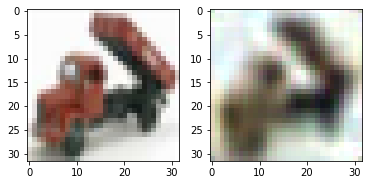

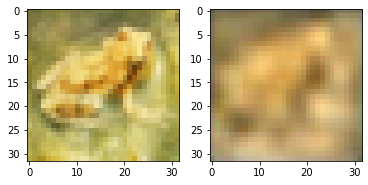

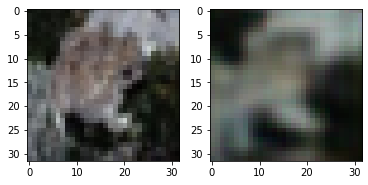

In [9]:
imgs = next(iter(ds_train))[0]
for i in range(10):
    plt.subplot(1, 2, 1)
    plt.imshow(imgs[i].numpy().squeeze(), cmap='bone')
    plt.subplot(1, 2, 2, )
    plt.imshow(autoencoder(imgs[i][tf.newaxis]).numpy().squeeze(), cmap='bone')
    plt.show()

2.

In [10]:
#2.1
model = tfk.Sequential([
  tfkl.InputLayer(img_shape),
  tfkl.Conv2D(16,(4,4),strides=(2,2), activation=tf.nn.relu,padding="same"),
  tfkl.MaxPooling2D((4,4),padding="same"),
  tfkl.Conv2D(32,(2,2), activation=tf.nn.relu,padding="same"),
  tfkl.MaxPooling2D((2,2),padding="same"),
  tfkl.Conv2D(32,(2,2), activation=tf.nn.relu,padding="same"),
  tfkl.MaxPooling2D((2,2),padding="same"),
  tfkl.Flatten(),
  tfkl.Dense(64,activation="sigmoid"),
  tfkl.Dense(10,activation="softmax")
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 16, 16, 16)        784       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 32)          2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 2, 2, 32)          4128      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 1, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 32)               

In [11]:
model.compile(
  optimizer=tfk.optimizers.Adam(),
  loss=tfk.losses.CategoricalCrossentropy(),
  metrics=[tfk.metrics.CategoricalAccuracy()],
)
preprocess = lambda d: (tf.cast(d["image"], tf.float32)/255, tf.one_hot(d["label"], depth=10))

ds_train = data['train'].map(preprocess).cache().batch(8)
ds_test = data["test"].map(preprocess).cache().batch(8)

In [ ]:
results = model.fit(ds_train, steps_per_epoch=100, epochs=20, validation_data=ds_test)

Epoch 1/20
100/100 [==============================] - 3s 25ms/step - loss: 1.6292 - categorical_accuracy: 0.3963 - val_loss: 1.5691 - val_categorical_accuracy: 0.4172
Epoch 2/20
100/100 [==============================] - 2s 20ms/step - loss: 1.6373 - categorical_accuracy: 0.3938 - val_loss: 1.5514 - val_categorical_accuracy: 0.4300
Epoch 3/20
100/100 [==============================] - 2s 20ms/step - loss: 1.5208 - categorical_accuracy: 0.4512 - val_loss: 1.5490 - val_categorical_accuracy: 0.4239
Epoch 4/20
100/100 [==============================] - 2s 21ms/step - loss: 1.5470 - categorical_accuracy: 0.4263 - val_loss: 1.6068 - val_categorical_accuracy: 0.4194
Epoch 5/20
100/100 [==============================] - 2s 21ms/step - loss: 1.5869 - categorical_accuracy: 0.4200 - val_loss: 1.5520 - val_categorical_accuracy: 0.4307
Epoch 6/20
100/100 [==============================] - 2s 22ms/step - loss: 1.5324 - categorical_accuracy: 0.4400 - val_loss: 1.5090 - val_categorical_accuracy: 0.446

In [12]:
#2.2
base = tfk.applications.MobileNetV2(input_shape=img_shape,
                                include_top=False,
                                weights='imagenet')
base.trainable = False
base.summary()

9412608/9406464 [==============================] - 2s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 33, 33, 3)    0           input_5[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 16, 16, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 16, 16, 32)   128         Conv1[0][0]                      
________________

In [13]:
#model2 = base(ds_train, training=False)

inputs = tfk.Input(shape=img_shape)
x = base(inputs, training=False)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
x = global_average_layer(x)
prediction_layer = tf.keras.layers.Dense(10, activation="softmax")
outputs = prediction_layer(x)

model2 = tfk.Model(inputs, outputs)

In [14]:
model2.compile(optimizer=tfk.optimizers.Adam(),
              loss=tfk.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [22]:
results2 = model2.fit(ds_train, epochs=20, validation_data=ds_test)

Epoch 1/20
6250/6250 [==============================] - 99s 16ms/step - loss: 1.9907 - accuracy: 0.2927 - val_loss: 1.9211 - val_accuracy: 0.3067
Epoch 2/20
6250/6250 [==============================] - 92s 15ms/step - loss: 1.8998 - accuracy: 0.3152 - val_loss: 1.9015 - val_accuracy: 0.3098
Epoch 3/20
6250/6250 [==============================] - 88s 14ms/step - loss: 1.8848 - accuracy: 0.3202 - val_loss: 1.8963 - val_accuracy: 0.3146
Epoch 4/20
6250/6250 [==============================] - 95s 15ms/step - loss: 1.8782 - accuracy: 0.3220 - val_loss: 1.8946 - val_accuracy: 0.3169
Epoch 5/20
6250/6250 [==============================] - 96s 15ms/step - loss: 1.8744 - accuracy: 0.3231 - val_loss: 1.8941 - val_accuracy: 0.3181
Epoch 6/20
6250/6250 [==============================] - 87s 14ms/step - loss: 1.8719 - accuracy: 0.3243 - val_loss: 1.8942 - val_accuracy: 0.3180
Epoch 7/20
6250/6250 [==============================] - 86s 14ms/step - loss: 1.8701 - accuracy: 0.3245 - val_loss: 1.8946 -

## 3 

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("SPAM_detection.csv")

In [4]:
df.head()

,Message,category_val
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [6]:
df["Message"] = df["Message"].str.lower()

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words="english",max_features=1000)
X = tfidf.fit_transform(df["Message"]).toarray()
Y = df["category_val"].values

X_train =X[:, :, None]

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, Y, test_size=0.2, random_state=0)

In [49]:
#LSTM
model = tfk.Sequential()
model.add(tfkl.LSTM(64, input_shape=X_train.shape[1:]))
model.add(tfkl.Dense(8,activation="relu"))
model.add(tfkl.Dense(1,activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer=tfk.optimizers.Adam(),metrics=["accuracy"])
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_19 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 9         
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [50]:
model.fit(X_train,y_train,epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
140/140 [==============================] - 42s 303ms/step - loss: 0.4280 - accuracy: 0.8676 - val_loss: 0.4115 - val_accuracy: 0.8565
Epoch 2/20
140/140 [==============================] - 34s 242ms/step - loss: 0.3915 - accuracy: 0.8683 - val_loss: 0.4159 - val_accuracy: 0.8565
Epoch 3/20
140/140 [==============================] - 34s 240ms/step - loss: 0.3901 - accuracy: 0.8683 - val_loss: 0.4113 - val_accuracy: 0.8565
Epoch 4/20
140/140 [==============================] - 34s 244ms/step - loss: 0.3910 - accuracy: 0.8683 - val_loss: 0.4147 - val_accuracy: 0.8565
Epoch 5/20
140/140 [==============================] - 34s 244ms/step - loss: 0.3908 - accuracy: 0.8683 - val_loss: 0.4166 - val_accuracy: 0.8565
Epoch 6/20
140/140 [==============================] - 34s 245ms/step - loss: 0.3912 - accuracy: 0.8683 - val_loss: 0.4125 - val_accuracy: 0.8565
Epoch 7/20
140/140 [==============================] - 35s 250ms/step - loss: 0.3903 - accuracy: 0.8683 - val_loss: 0.4111 - val_ac

In [51]:
cnn1d_model = tfk.Sequential()
cnn1d_model.add(tfkl.Conv1D(16, 3, activation='relu',input_shape=X_train.shape[1:]))
cnn1d_model.add(tfkl.MaxPooling1D(pool_size=2,strides=1, padding='valid'))
cnn1d_model.add(tfkl.Conv1D(32, 3, activation='relu'))
cnn1d_model.add(tfkl.MaxPooling1D(pool_size=2,strides=1, padding='valid'))
cnn1d_model.add(tfkl.Flatten())
cnn1d_model.add(tfkl.Dense(8,activation="relu"))
cnn1d_model.add(tfkl.Dense(1,activation="sigmoid"))
cnn1d_model.compile(loss='binary_crossentropy', optimizer=tfk.optimizers.Adam(),metrics=["accuracy"])
cnn1d_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 998, 16)           64        
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 997, 16)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 995, 32)           1568      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 994, 32)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 31808)             0         
_________________________________________________________________
dense_21 (Dense)             (None, 8)                 254472    
_________________________________________________________________
dense_22 (Dense)             (None, 1)               

In [52]:
cnn1d_model.fit(X_train,y_train,epochs=10,validation_data=(X_test, y_test))

Epoch 1/10
140/140 [==============================] - 3s 24ms/step - loss: 0.2897 - accuracy: 0.8670 - val_loss: 0.1769 - val_accuracy: 0.9641
Epoch 2/10
140/140 [==============================] - 3s 25ms/step - loss: 0.1440 - accuracy: 0.9697 - val_loss: 0.1622 - val_accuracy: 0.9749
Epoch 3/10
140/140 [==============================] - 4s 26ms/step - loss: 0.1059 - accuracy: 0.9735 - val_loss: 0.1021 - val_accuracy: 0.9767
Epoch 4/10
140/140 [==============================] - 4s 26ms/step - loss: 0.0557 - accuracy: 0.9814 - val_loss: 0.0936 - val_accuracy: 0.9794
Epoch 5/10
140/140 [==============================] - 3s 25ms/step - loss: 0.0420 - accuracy: 0.9870 - val_loss: 0.1060 - val_accuracy: 0.9785
Epoch 6/10
140/140 [==============================] - 3s 25ms/step - loss: 0.0346 - accuracy: 0.9904 - val_loss: 0.0921 - val_accuracy: 0.9821
Epoch 7/10
140/140 [==============================] - 3s 25ms/step - loss: 0.0264 - accuracy: 0.9937 - val_loss: 0.0943 - val_accuracy: 0.9803

In [53]:
from sklearn.metrics import roc_curve

In [54]:
y_pred_lstm = model.predict(X_test).ravel()
fpr_lstm, tpr_lstm, thresholds_lstm = roc_curve(y_test, y_pred_lstm)

y_pred_cnn = cnn1d_model.predict(X_test).ravel()
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, y_pred_cnn)

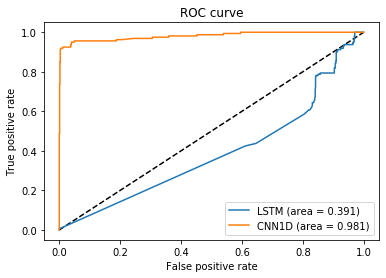

In [56]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc

auc_lstm = auc(fpr_lstm, tpr_lstm)
auc_cnn = auc(fpr_cnn, tpr_cnn)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lstm, tpr_lstm, label='LSTM (area = {:.3f})'.format(auc_lstm))
plt.plot(fpr_cnn, tpr_cnn, label='CNN1D (area = {:.3f})'.format(auc_cnn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Pytorch 

In [61]:
import torch
import torchvision
import torchvision.transforms as transforms

In [62]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

0.00B [00:00, ?B/s]

100%|█████████▉| 170M/170M [00:31<00:00, 5.91MB/s] 

Files already downloaded and verified


171MB [00:50, 5.91MB/s]                           

In [75]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [76]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [78]:
import numpy as np

dataiter = iter(trainloader)
images, labels = dataiter.next()

for epoch in range(2):  

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.183
[1,  4000] loss: 1.193
[1,  6000] loss: 1.172
[1,  8000] loss: 1.174
[1, 10000] loss: 1.154
[1, 12000] loss: 1.162
[2,  2000] loss: 1.074
[2,  4000] loss: 1.081
[2,  6000] loss: 1.073
[2,  8000] loss: 1.098
[2, 10000] loss: 1.076
[2, 12000] loss: 1.077
Finished Training
